In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
if '/content/drive/MyDrive/images/modules' not in sys.path:
    sys.path.append('/content/drive/MyDrive/images/modules')

!pip install -U tensorflow-addons

Mounted at /content/drive
     |████████████████████████████████| 706kB 9.2MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [2]:
from google.colab.patches import cv2_imshow
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import tensorflow_datasets as tfds 
import random
import tensorflow_addons as tfa
import os
import re
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio
import toPNG
import ImageGenerator
import ImpModel
import Inference
from tensorflow.keras.callbacks import TensorBoard
import imp
import time

In [3]:
images_dir = '/content/drive/My Drive/images/'

In [4]:
bsd300 = glob.glob(images_dir+'main_images/BSD300/*.png')
bsd68 = glob.glob(images_dir+'main_images/CBSD68/*.png')
bsd500 = glob.glob(images_dir+'main_images/BSD500/train/*.jpg')

In [6]:
stddevs = np.random.uniform(1, 55.0, 125000)[:, np.newaxis, np.newaxis, np.newaxis]
noise = np.random.normal(loc = 0, scale=stddevs, size=(125000, 50, 50, 3)).astype(np.float16)

In [7]:
test_images = []
for path in bsd68:
    test_images.append(cv2.imread(path))

In [8]:
def _reconstruct_from_patches(patches, h, w, true_h, true_w, patch_size):
        img = np.zeros((h,w, patches[0].shape[-1]))
        counter = 0
        for i in range(0,h,patch_size):
            for j in range(0,w,patch_size):
                img[i:i+patch_size, j:j+patch_size, :] = patches[counter]
                counter+=1
        return cv2.resize(img, (true_w, true_h), cv2.INTER_CUBIC)

def inferencePipeline(model, patch_size, stddev):
    noise_images = []
    pred_images = []
    for true_img in test_images:

        scale_h, scale_w = true_img.shape[0]//patch_size * patch_size, true_img.shape[1]//patch_size * patch_size
        resize_img = cv2.resize(true_img, (scale_w, scale_h), cv2.INTER_CUBIC)
        noise_img = (resize_img/255.0) + np.random.normal(scale=stddev/255.0, size=(resize_img.shape))
        noise_img = np.clip(noise_img, 0, 1).astype(np.float32)
        
        patches = []
        for i in range(0, noise_img.shape[0] - patch_size + 1, patch_size):
            for j in range(0, noise_img.shape[1] - patch_size + 1, patch_size):
                patches.append(noise_img[i:i+patch_size, j:j+patch_size, :])
        patches = np.array(patches)
        pred = model(patches)
        pred_images.append(np.floor(_reconstruct_from_patches(pred, scale_h, scale_w, true_img.shape[0], 
                                                     true_img.shape[1], patch_size)*255.0))
        noise_images.append(np.floor(_reconstruct_from_patches(patches, scale_h, scale_w, true_img.shape[0], 
                                                      true_img.shape[1], patch_size)*255.0))
    score = np.mean([peak_signal_noise_ratio(test_images[i], (pred_images[i])) for i in range(len(test_images))])
    print(f'PSNR value for Predictions (std {stddev}) : {score}')
    return noise_images, pred_images

In [9]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        _ = inferencePipeline(self.model, 50, 25.0)
        _ = inferencePipeline(self.model, 50, 50.0)

In [10]:
def transformation(img, choice):
    if choice == 1:
        return img
    elif choice == 2:
        return tfa.image.rotate(img, tf.constant(np.pi))
    elif choice == 3:
        return tfa.image.rotate(img, tf.constant(2*np.pi))
    elif choice == 4:
        return tfa.image.rotate(img, tf.constant(3*np.pi))
    elif choice == 5:
        return tf.image.flip_left_right(img)
    elif choice == 6:
        return tf.image.flip_left_right(tfa.image.rotate(img, tf.constant(np.pi)))
    elif choice == 7:
        return tf.image.flip_left_right(tfa.image.rotate(img, tf.constant(2*np.pi)))
    else:
        return tf.image.flip_left_right(tfa.image.rotate(img, tf.constant(3*np.pi)))

def handle_augment_data(noise, true):
    choice = np.random.randint(1, 9)
    return (transformation(noise[0], choice),), transformation(true, choice) 
def get_dataset(img_path):
    def image_generator():
        patch_size = 50
        stride = 20
        index = 0
        for scale in [1, 0.9, 0.8, 0.7]:
            for path in img_path:
                true_img = cv2.imread(path)
                for i in range(0, true_img.shape[0] - patch_size + 1, stride):
                    for j in range(0, true_img.shape[1] - patch_size + 1, stride):
                        Y = true_img[i:i+patch_size, j:j+patch_size]
                        gauss_noise = noise[index].astype(np.float32)
                        X = np.clip(Y + gauss_noise, 0, 255.0)
                        index = (index + 1)%125000
                        yield (X/255.0,),Y/255.0
    return tf.data.Dataset.from_generator(image_generator, output_signature=((tf.TensorSpec(shape=(None, None, 3)),),(tf.TensorSpec(shape=(None, None, 3)))))

In [5]:
class BatchNormalization(tf.keras.layers.Layer):
    def __init__(self, momentum, epsilon, movingMean, movingVariance):
        super(BatchNormalization, self).__init__()
        self.momentum = tf.constant(momentum, dtype=tf.float32)
        self.epsilon = tf.constant(epsilon,dtype=tf.float32)
        self.movingMean = (movingMean)
        self.movingVariance = (movingVariance)
    
    def build(self, input_shape):
        self.movingMean = tf.Variable(initial_value=self.movingMean*tf.ones((1, 1, 1, input_shape[-1])), 
                                      dtype=tf.float32, trainable=False, name='v1')
        self.movingVariance = tf.Variable(initial_value=self.movingVariance*tf.ones((1, 1, 1, input_shape[-1])), 
                                          dtype=tf.float32, trainable=False, name='v1')
        self.beta = self.add_weight(
            shape=(1, 1, 1, input_shape[-1]), dtype=tf.float32, 
            initializer='zeros', trainable=True, name='w1'
        )
        self.gamma = self.add_weight(
            shape=(1, 1, 1, input_shape[-1]), dtype=tf.float32, 
            initializer='ones', trainable=True, name='w2'
        )
    
    def call(self, inputs, training=False):
        if not training:
            return tf.nn.batch_normalization(inputs, self.movingMean, self.movingVariance, self.beta, self.gamma, self.epsilon)
        else:
            batchMean, batchVariance = tf.nn.moments(inputs, axes=[0,1,2])
            batchMean = tf.reshape(batchMean, shape=(1,1,1,-1))
            batchVariance = tf.reshape(batchVariance, shape=(1,1,1,-1))
            
            movingMean=self.movingMean*(1-self.momentum) + batchMean*self.momentum
            movingVariance=self.movingVariance*(1-self.momentum) + batchVariance*self.momentum
            
            self.movingMean.assign(movingMean)
            self.movingVariance.assign(movingVariance)

            return tf.nn.batch_normalization(inputs, batchMean, batchVariance, self.beta, self.gamma, self.epsilon)

def get_model(depth=11, channels=3):
    noise_inp = tf.keras.layers.Input(shape = (None, None, channels), dtype=tf.float32, name = 'noise_inp')
    init = 'Orthogonal'
    
    y = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', kernel_initializer=init, 
        use_bias=True)(noise_inp)
    y = tf.keras.layers.ReLU()(y)
    for i in range(1, depth-1):
        y = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', kernel_initializer=init, 
            use_bias=True)(y)
        #bn = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.95)
        bn = BatchNormalization(0.1, 1e-3, 0, 1)
        y = bn(y)
        y = tf.keras.layers.ReLU()(y)
    residual = tf.keras.layers.Conv2D(filters = channels, kernel_size = 3, padding = 'same', kernel_initializer=init, 
        use_bias=True, name='residual')(y)
    
    true_img = tf.keras.layers.Subtract()([noise_inp, residual])
    model = tf.keras.Model(inputs = [noise_inp], outputs=[true_img])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

    return model
model = get_model(12)

In [ ]:
def lr_decay(epoch):
    lr = 1e-3
    if epoch+1 > 30:
        lr/=20
    elif epoch+1 > 20:
        lr /= 10
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay)
dataset = get_dataset(bsd500).shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE).repeat(None)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
history = model.fit(x = dataset, steps_per_epoch=1000, epochs=50, shuffle=True,verbose=1,
                callbacks=[CustomCallback(), lr_callback])

Epoch 1/50
1000/1000 [==============================] - 398s 396ms/step - loss: 0.0213


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


PSNR value for Predictions (std 25.0) : 25.680069814851418
PSNR value for Predictions (std 50.0) : 23.30365192975636
Epoch 2/50
1000/1000 [==============================] - 396s 396ms/step - loss: 0.0024
PSNR value for Predictions (std 25.0) : 27.382127155257987
PSNR value for Predictions (std 50.0) : 24.709617803807582
Epoch 3/50
1000/1000 [==============================] - 396s 396ms/step - loss: 0.0018
PSNR value for Predictions (std 25.0) : 27.154297160829874
PSNR value for Predictions (std 50.0) : 24.612273482811414
Epoch 4/50
1000/1000 [==============================] - 396s 396ms/step - loss: 0.0016
PSNR value for Predictions (std 25.0) : 27.56874250617122
PSNR value for Predictions (std 50.0) : 24.991995590968255
Epoch 5/50
1000/1000 [==============================] - 396s 396ms/step - loss: 0.0016
PSNR value for Predictions (std 25.0) : 27.708425886106085
PSNR value for Predictions (std 50.0) : 25.2181768597848
Epoch 6/50
1000/1000 [==============================] - 396s 396ms

In [6]:
model.load_weights('/content/drive/MyDrive/images/models/tf/tf/model-blind')

In [52]:
noise_images, pred_images = inferencePipeline(model, 50, 50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


PSNR value for Predictions (std 50) : 26.131604940213972


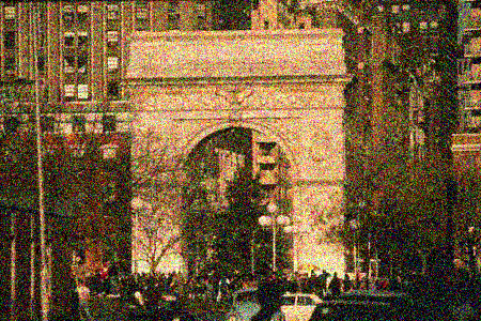

In [55]:
cv2_imshow(noise_images[20])

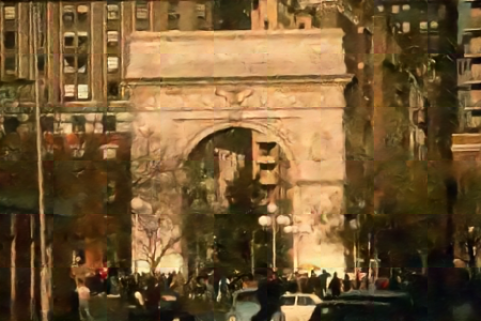

In [57]:
cv2_imshow(pred_images[20])

# Adding Gaussian Noise (25 Standard Deviation) to Original Image

In [9]:
img = cv2.imread(f'{images_dir}gopro/37.png')
stddev = 25

H, W = img.shape[:-1]
scale_h, scale_w = H//50 * 50, W//50 * 50
resize_img = cv2.resize(img, (scale_w, scale_h), cv2.INTER_CUBIC)

noise_img = np.clip(np.random.normal(scale=stddev/255.0, size=(scale_h, scale_w, 3)) + resize_img/255.0, 0, 1)

patches = []
for i in range(0, noise_img.shape[0] - 50 + 1, 50):
    for j in range(0, noise_img.shape[1] - 50 + 1, 50):
        patches += [noise_img[i:i+50, j:j+50, :]]

patches = np.array(patches).astype(np.float32)
predictions = model((patches))
predictions = np.clip(predictions, 0, 1)

pred_img = _reconstruct_from_patches(predictions, scale_h, scale_w, H, W, 50)*255

print(f'{stddev} stddev : ' + str(peak_signal_noise_ratio(img, pred_img)))

25 stddev : 29.567514369357536


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


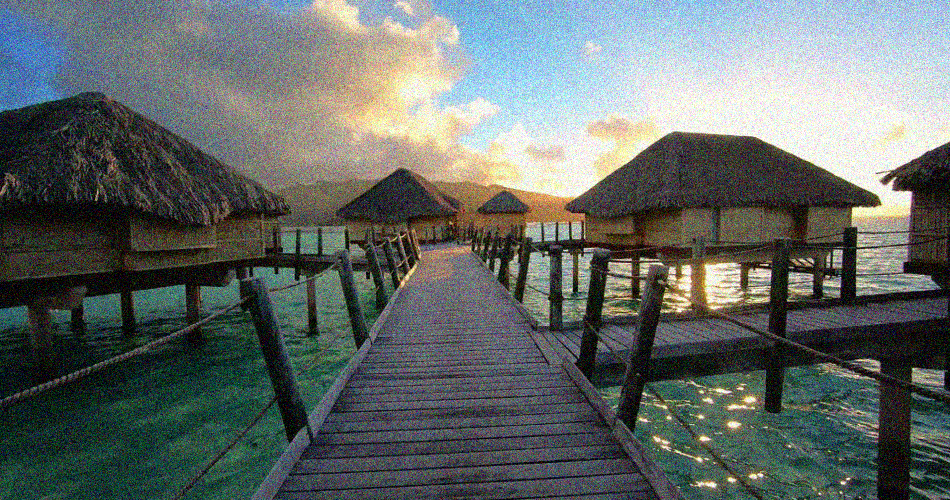

In [10]:
cv2_imshow(noise_img*255.0)

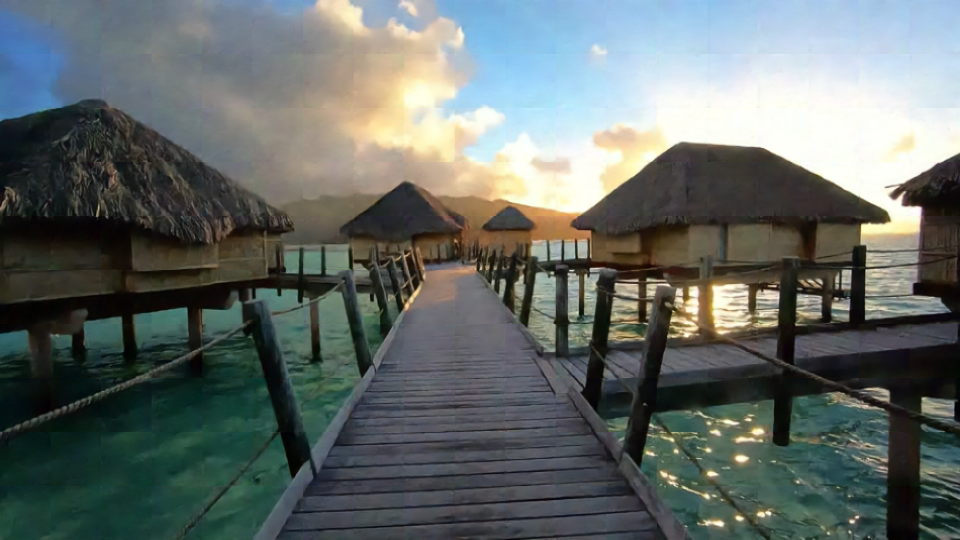

In [11]:
cv2_imshow(pred_img)

# Adding Gaussian Noise (50 Standard Deviation) to Original Image

In [12]:
img = cv2.imread(f'{images_dir}gopro/37.png')
stddev = 50

H, W = img.shape[:-1]
scale_h, scale_w = H//50 * 50, W//50 * 50
resize_img = cv2.resize(img, (scale_w, scale_h), cv2.INTER_CUBIC)

noise_img = np.clip(np.random.normal(scale=stddev/255.0, size=(scale_h, scale_w, 3)) + resize_img/255.0, 0, 1)

patches = []
for i in range(0, noise_img.shape[0] - 50 + 1, 50):
    for j in range(0, noise_img.shape[1] - 50 + 1, 50):
        patches += [noise_img[i:i+50, j:j+50, :]]

patches = np.array(patches).astype(np.float32)
predictions = model((patches))
predictions = np.clip(predictions, 0, 1)

pred_img = _reconstruct_from_patches(predictions, scale_h, scale_w, H, W, 50)*255

print(f'{stddev} stddev : ' + str(peak_signal_noise_ratio(img, pred_img)))

50 stddev : 27.28788580537703


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


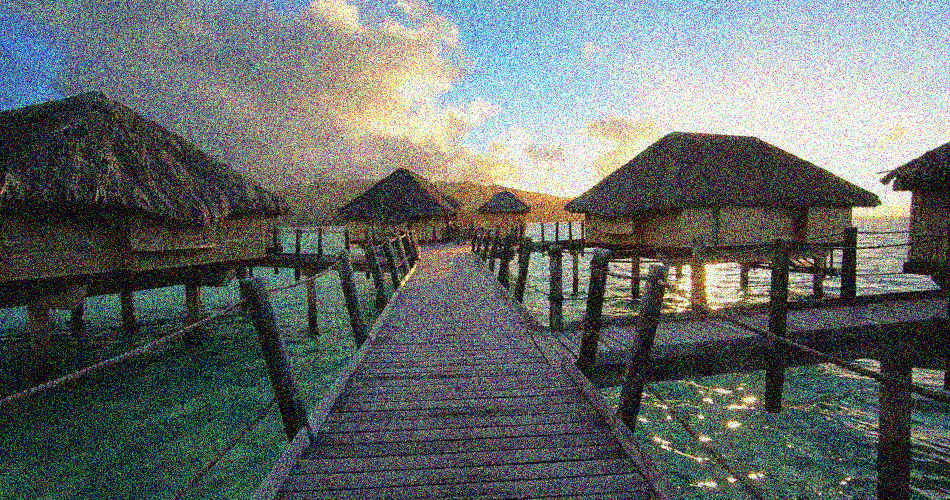

In [13]:
cv2_imshow(noise_img*255.0)

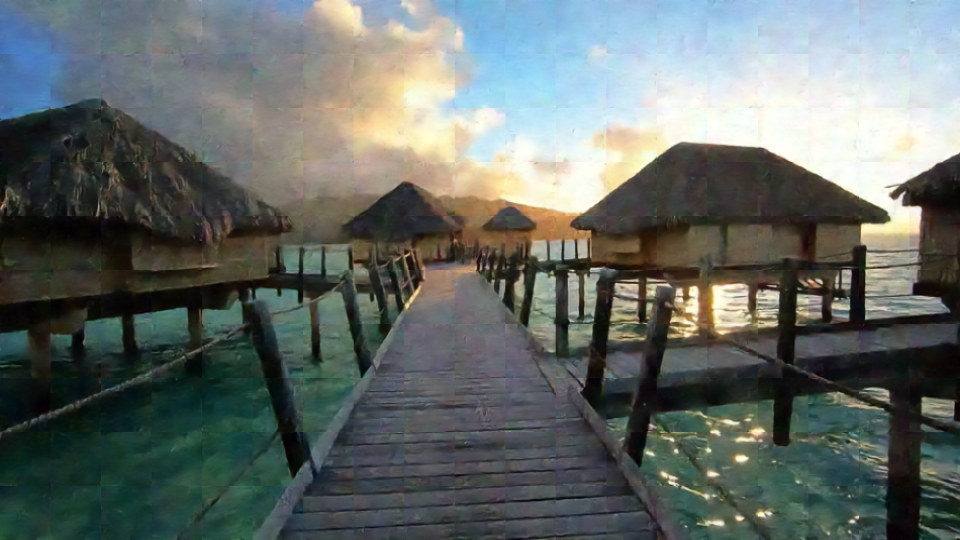

In [14]:
cv2_imshow(pred_img)